# Visualization Creation Notebook

This notebook creates visualizations based on the data in the dataframe object, sometimes with added computations, for:

- Model Performance
- Agent Agreement and Cohen's Kappa
- AUPRC
- Span Aggregation Metrics such as AS, AD and NAD
- Span Separation Metrics Cohen's d and ROC-AUC (Distributions on one span, as well as overview tables over all spans)
- Task Succes Rate Correlation (Single span correlation plot as well as Overview Table and Table with combined spans)

---
**Input Data:** `data/results_dataframe.parquet`

Model Performance Tables
---------------------

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import os
from datetime import datetime

# =============================================================================
# --- CONFIGURATION ---
# =============================================================================

DATA_FILEPATH = "../data/results_dataframe.parquet"
VIS_OUTPUT_DIR = "../visualization/tables"

# Row Grouping
ROW_GROUPING_COL = 'category'

# Visual Settings
FIG_WIDTH = 7   
FIG_HEIGHT = 3
SNS_STYLE = 'white'

# Standard Accuracy Settings
COLORMAP_ACC = 'Greens' 
VMIN_ACC = 0
VMAX_ACC = 100

# Delta Settings (Planning - Use)
COLORMAP_DELTA = 'vlag' 
VMIN_DELTA = 0 
VMAX_DELTA = 20

# Display Names for Categories (Optional mapping)
CATEGORY_DISPLAY_NAMES = {
    'business_and_productivity': 'Business & Productivity',
    'data': 'Data',
    'entertainment_and_media': 'Entertainment & Media',
    'finance': 'Finance',
    'travel_and_transportation': 'Travel & Transportation',
    'Total': 'Total'
}

# =============================================================================
# --- HELPER FUNCTIONS ---
# =============================================================================

def load_data(filepath):
    """Loads the dataframe and handles basic error checking."""
    if not os.path.exists(filepath):
        print(f"Error: File not found at {filepath}")
        return None
    try:
        df = pd.read_parquet(filepath)
        return df
    except Exception as e:
        print(f"Error loading parquet: {e}")
        return None

def generate_data_and_annotations(df, metric_col):
    """
    Calculates correct counts, total counts, and percentages.
    Returns:
        percentages (pd.DataFrame): For heatmap coloring.
        annotations (pd.DataFrame): Strings formatted as 'Pct% (Count)'.
    """
    # 1. Deduplicate: One row per task_model_id
    unique_df = df.drop_duplicates(subset=['task_model_id']).copy()
    
    # Ensure the metric column is int (0/1)
    unique_df[metric_col] = unique_df[metric_col].astype(int)

    # 2. Calculate Numerator (Count of Correct)
    correct_counts = pd.crosstab(
        index=unique_df[ROW_GROUPING_COL], 
        columns=unique_df['model'], 
        values=unique_df[metric_col], 
        aggfunc='sum',
        margins=True,
        margins_name='Total'
    ).fillna(0)

    # 3. Calculate Denominator (Total Count of Tasks)
    total_counts = pd.crosstab(
        index=unique_df[ROW_GROUPING_COL], 
        columns=unique_df['model'], 
        values=unique_df[metric_col],
        aggfunc='count',
        margins=True,
        margins_name='Total'
    ).fillna(0)

    # 4. Calculate Percentages
    percentages = (correct_counts / total_counts * 100).fillna(0)

    # 5. Create Annotation Matrix (Strings)
    annot_matrix = pd.DataFrame(index=correct_counts.index, columns=correct_counts.columns)
    
    for r in correct_counts.index:
        for c in correct_counts.columns:
            count = int(correct_counts.loc[r, c])
            pct = percentages.loc[r, c]
            annot_matrix.loc[r, c] = f"{pct:.1f}% ({count})"
            
    return percentages, annot_matrix

def save_heatmap(data, annot_labels, title, filename_suffix, cmap, vmin, vmax, center=None, cbar_label='Accuracy (%)'):
    """
    Plots and saves the dataframe as a Seaborn heatmap PNG.
    """
    # 1. Rename Rows if mapping exists
    data = data.rename(index=CATEGORY_DISPLAY_NAMES)
    annot_labels = annot_labels.rename(index=CATEGORY_DISPLAY_NAMES)
    
    # 2. Setup Plot
    sns.set_theme(style=SNS_STYLE)
    plt.figure(figsize=(FIG_WIDTH, FIG_HEIGHT))
    
    # 3. Create Heatmap
    ax = sns.heatmap(
        data,
        annot=annot_labels,
        fmt='', 
        cmap=cmap,
        linewidths=0.5,
        vmin=vmin, 
        vmax=vmax,
        center=center,
        cbar_kws={'label': cbar_label}
    )
    
    # 4. Styling
    plt.title(title, fontsize=16, pad=20)
    plt.xlabel("Model", fontsize=12)
    plt.ylabel("Task Category", fontsize=12)
    plt.xticks(rotation=45, ha='right')
    plt.yticks(rotation=0)
    
    # 5. Save
    timestamp = datetime.now().strftime("%d%m_%H%M%S")
    filename = f"{filename_suffix}_{timestamp}.png"
    
    os.makedirs(VIS_OUTPUT_DIR, exist_ok=True)
    output_path = os.path.join(VIS_OUTPUT_DIR, filename)
    
    plt.savefig(output_path, bbox_inches='tight', dpi=300)
    plt.close()
    
    print(f"✅ Saved plot: {output_path}")

# =============================================================================
# --- MODES ---
# =============================================================================

def accuracy_plan_per_model(df):
    """
    Mode 1: Generates heatmap for 'tool_plan_correct'.
    """
    print("\n--- Generating Plan Accuracy Heatmap ---")
    
    # 1. Get Data
    pct_data, annot_data = generate_data_and_annotations(df, 'tool_plan_correct')
    
    # 2. Plot
    title = "Performance: Planning Accuracy"
    save_heatmap(pct_data, annot_data, title, "accuracy_plan_heatmap", 
                 cmap=COLORMAP_ACC, vmin=VMIN_ACC, vmax=VMAX_ACC, cbar_label=r"$\tau^*$ Planning (%)")

def accuracy_use_per_model(df):
    """
    Mode 2: Generates heatmap for 'tool_use_correct'.
    """
    print("\n--- Generating Tool Use Accuracy Heatmap ---")
    
    # 1. Get Data
    pct_data, annot_data = generate_data_and_annotations(df, 'tool_use_correct')
    
    # 2. Plot
    title = "Performance: Tool Use Accuracy"
    save_heatmap(pct_data, annot_data, title, "accuracy_use_heatmap", 
                 cmap=COLORMAP_ACC, vmin=VMIN_ACC, vmax=VMAX_ACC)

def delta_plan_minus_use(df):
    """
    Mode 3: Generates Delta Heatmap (Plan % - Use %).
    Positive = Better at Planning. Negative = Better at Use.
    Shows: "AbsDeltaPct% (AbsDeltaCount)"
    """
    print("\n--- Generating Delta Heatmap (Plan - Use) ---")
    
    # 1. Calculate Percentages and get Text Annotations for both
    pct_plan, annot_plan = generate_data_and_annotations(df, 'tool_plan_correct')
    pct_use, annot_use = generate_data_and_annotations(df, 'tool_use_correct')
    
    # 2. Calculate Delta Percentage
    delta_pct = pct_plan - pct_use
    
    # 3. Extract Absolute Counts from the string annotations
    def get_count_from_string(s):
        try:
            part = str(s).split('(')[1] 
            return int(part.replace(')', '').strip())
        except (ValueError, IndexError):
            return 0

    count_plan = annot_plan.map(get_count_from_string)
    count_use = annot_use.map(get_count_from_string)
    
    # 4. Calculate Delta Count
    delta_count = count_plan - count_use
    
    # 5. Create Combined Annotation Matrix
    annot_matrix = pd.DataFrame(index=delta_pct.index, columns=delta_pct.columns)
    
    for r in delta_pct.index:
        for c in delta_pct.columns:
            d_cnt = int(delta_count.loc[r, c])
            d_pct = delta_pct.loc[r, c]
            annot_matrix.loc[r, c] = f"{abs(d_pct):.1f}% ({abs(d_cnt)})"
    
    # 6. Plot
    title = "Delta: Planning Accuracy - Tool Use Accuracy"
    save_heatmap(
        delta_pct, 
        annot_matrix, 
        title, 
        "delta_plan_minus_use_heatmap",
        cmap=COLORMAP_DELTA,
        vmin=VMIN_DELTA,
        vmax=VMAX_DELTA,
        center=0,
        cbar_label=r"$\tau^*$ Planning (%) - Accuracy"
    )

# =============================================================================
# --- MAIN ---
# =============================================================================

if __name__ == "__main__":
    print(f"Loading data from: {DATA_FILEPATH}")
    df = load_data(DATA_FILEPATH)
    
    if df is not None:
        # Run all modes
        accuracy_plan_per_model(df)
        accuracy_use_per_model(df)
        delta_plan_minus_use(df)
        
        print("\nDone.")

Loading data from: ../data/results_dataframe.parquet

--- Generating Plan Accuracy Heatmap ---
✅ Saved plot: ../visualization/tables/accuracy_plan_heatmap_1612_014636.png

--- Generating Tool Use Accuracy Heatmap ---
✅ Saved plot: ../visualization/tables/accuracy_use_heatmap_1612_014636.png

--- Generating Delta Heatmap (Plan - Use) ---
✅ Saved plot: ../visualization/tables/delta_plan_minus_use_heatmap_1612_014636.png

Done.


Compute and Plot Agreement & Kappa Table
----------------------------

In [2]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import os
import re
from datetime import datetime

# =============================================================================
# --- 1. CONFIGURATION ---
# =============================================================================

DATA_FILEPATH = "../data/results_dataframe.parquet"
VIS_OUTPUT_DIR = "../visualization/tables"

# Mapping raw category names to display names
CATEGORY_DISPLAY_NAMES = {
    'business_and_productivity': 'Business & Productivity',
    'data': 'Data',
    'entertainment_and_media': 'Entertainment & Media',
    'finance': 'Finance',
    'travel_and_transportation': 'Travel & Transportation',
    'Total': 'Total' 
}

# Column display names for the two specific modes
COLUMN_DISPLAY_NAMES = {
    'total_agreement': r"Accuracy Agreement",
    'shared_failure': 'Shared Failures',
    'cohen_kappa': r"Cohen's Kappa Accuracy"
}

# --- Styling ---
SNS_STYLE = 'white'
COLORMAP = 'coolwarm'
CCENTER_VALUE = 0  # Center colormap at 0 for diverging logic
NUMBER_FORMAT = ".2f"
CELL_BORDER_WIDTH = 0.3
FIG_WIDTH = 5
FIG_HEIGHT = 4

# =============================================================================
# --- 2. CORE LOGIC ---
# =============================================================================

def prepare_table(df, mode):
    """
    Calculates the table specifically for 'model_agreement' or 'cohen_kappa'.
    """
    print(f"--- Calculating table for mode: {mode} ---")
    
    # 1. Deduplicate: Use task_model_id if available to identify unique runs
    if 'task_model_id' in df.columns:
            df_unique = df.drop_duplicates(subset=['task_model_id']).copy()
    else:
            df_unique = df.drop_duplicates(subset=['task_id', 'model']).copy()

    # 2. Identify the two models automatically
    models = sorted(list(df_unique['model'].unique()))
    if len(models) != 2:
        raise ValueError(f"Agreement metrics require exactly 2 models. Found {len(models)}: {models}")
    
    model_a, model_b = models[0], models[1]
    print(f"Comparing: {model_a} vs {model_b}")
    
    # 3. Pivot: Index=task_id, Columns=model, Values=tool_use_correct (True/False)
    df_pivot = df_unique.pivot(index='task_id', columns='model', values='tool_use_correct')
    
    # Add category back to the pivoted dataframe
    task_categories = df_unique.set_index('task_id')['category'].to_dict()
    df_pivot['category'] = df_pivot.index.map(task_categories)
    
    # Drop rows where one model might be missing data
    df_pivot = df_pivot.dropna(subset=[model_a, model_b])
    
    categories = sorted(list(df_pivot['category'].unique()))
    row_labels = categories + ['Total']
    
    # --- MODE: MODEL AGREEMENT ---
    if mode == 'model_agreement':
        col_labels = ['total_agreement', 'shared_failure']
        numeric_data = pd.DataFrame(index=row_labels, columns=col_labels, dtype=float)
        annot_data = pd.DataFrame(index=row_labels, columns=col_labels, dtype=object)
        
        def calc_agreement_stats(sub_df):
            n = len(sub_df)
            if n == 0: return 0.0, 0.0
            # Total Agreement: Both True OR Both False
            agree_mask = (sub_df[model_a] == sub_df[model_b])
            total_agree_pct = agree_mask.sum() / n
            # Shared Failure: Both False
            fail_mask = (~sub_df[model_a]) & (~sub_df[model_b])
            shared_fail_pct = fail_mask.sum() / n
            return total_agree_pct, shared_fail_pct

        # Per Category
        for cat in categories:
            cat_df = df_pivot[df_pivot['category'] == cat]
            ta, sf = calc_agreement_stats(cat_df)
            numeric_data.loc[cat] = [ta, sf]
            annot_data.loc[cat] = [f"{ta:.1%}", f"{sf:.1%}"]
            
        # Total
        ta, sf = calc_agreement_stats(df_pivot)
        numeric_data.loc['Total'] = [ta, sf]
        annot_data.loc['Total'] = [f"{ta:.1%}", f"{sf:.1%}"]
        
        return numeric_data, annot_data

    # --- MODE: COHEN KAPPA ---
    elif mode == 'cohen_kappa':
        col_labels = ['cohen_kappa']
        numeric_data = pd.DataFrame(index=row_labels, columns=col_labels, dtype=float)
        
        def calc_kappa_stats(sub_df):
            n = len(sub_df)
            if n == 0: return 0.0
            # Observed Agreement (Po)
            agree_count = (sub_df[model_a] == sub_df[model_b]).sum()
            p_o = agree_count / n
            
            # Expected Agreement (Pe)
            p_a_yes = sub_df[model_a].sum() / n
            p_b_yes = sub_df[model_b].sum() / n
            # Pe = (Prob Both Yes) + (Prob Both No)
            p_e = (p_a_yes * p_b_yes) + ((1 - p_a_yes) * (1 - p_b_yes))
            
            if p_e == 1: return 1.0
            return (p_o - p_e) / (1 - p_e)

        # Per Category
        for cat in categories:
            cat_df = df_pivot[df_pivot['category'] == cat]
            numeric_data.loc[cat, 'cohen_kappa'] = calc_kappa_stats(cat_df)
        
        # Total
        numeric_data.loc['Total', 'cohen_kappa'] = calc_kappa_stats(df_pivot)
        
        return numeric_data, None

    else:
        raise ValueError("Unsupported mode.")

def create_heatmap(table_data, annot_data, title, filename_suffix):
    """
    Generates and saves the heatmap. 
    """
    # Rename rows/cols for display
    safe_rename_index = {k:v for k,v in CATEGORY_DISPLAY_NAMES.items() if k in table_data.index}
    safe_rename_cols = {k:v for k,v in COLUMN_DISPLAY_NAMES.items() if k in table_data.columns}
    
    table_data = table_data.rename(index=safe_rename_index, columns=safe_rename_cols)
    
    if annot_data is not None:
        annot_data = annot_data.rename(index=safe_rename_index, columns=safe_rename_cols)
        annot_labels = annot_data.values
        fmt = "" 
    else:
        annot_labels = True 
        fmt = NUMBER_FORMAT

    print(f"Generating heatmap: {title}...")
    sns.set_theme(style=SNS_STYLE)
    plt.figure(figsize=(FIG_WIDTH, FIG_HEIGHT))
    
    sns.heatmap(
        table_data,
        annot=annot_labels,
        fmt=fmt,
        cmap=COLORMAP,
        center=CCENTER_VALUE,
        linewidths=CELL_BORDER_WIDTH,
        square=False
    )
    
    plt.title(title, fontsize=14, pad=20)
    plt.xlabel("Metrics", fontsize=12)
    plt.ylabel("Category", fontsize=12)
    plt.xticks(rotation=45, ha='right')
    plt.yticks(rotation=0)
    
    timestamp = datetime.now().strftime("%d%m_%H%M%S")
    filename = f"{filename_suffix}_{timestamp}.png"
    
    os.makedirs(VIS_OUTPUT_DIR, exist_ok=True)
    save_path = os.path.join(VIS_OUTPUT_DIR, filename)
    plt.savefig(save_path, bbox_inches='tight', dpi=300)
    plt.close()
    
    print(f"✅ Saved: {save_path}\n")

# =============================================================================
# --- 3. MAIN EXECUTION ---
# =============================================================================

if __name__ == "__main__":
    if not os.path.exists(DATA_FILEPATH):
        print(f"File not found: {DATA_FILEPATH}")
    else:
        print(f"Loading data from: {DATA_FILEPATH}")
        df_main = pd.read_parquet(DATA_FILEPATH)
        
        # We want to generate BOTH tables sequentially
        modes_to_run = [
            ("model_agreement", "Model Agreement & Shared Failures"),
            ("cohen_kappa", "Cohen's Kappa (Inter-Model Reliability)")
        ]

        for mode, title in modes_to_run:
            try:
                # Calculate
                data_res, annot_res = prepare_table(df_main, mode)
                
                # Visualize
                create_heatmap(
                    table_data=data_res, 
                    annot_data=annot_res, 
                    title=title,
                    filename_suffix=mode
                )
            except Exception as e:
                print(f"Failed to generate {mode}: {e}")
                import traceback
                traceback.print_exc()

Loading data from: ../data/results_dataframe.parquet
--- Calculating table for mode: model_agreement ---
Comparing: Qwen3-0.6B vs Qwen3-1.7B
Generating heatmap: Model Agreement & Shared Failures...
✅ Saved: ../visualization/tables/model_agreement_1612_014706.png

--- Calculating table for mode: cohen_kappa ---
Comparing: Qwen3-0.6B vs Qwen3-1.7B
Generating heatmap: Cohen's Kappa (Inter-Model Reliability)...
✅ Saved: ../visualization/tables/cohen_kappa_1612_014706.png



Plot AUPRC Distribution
-----------------------

Loading data from ../data/results_dataframe.parquet...
Mapping category names...
Plotting 327 unique tasks...
✅ Plot saved to ../visualization/plots/auprc_distribution_1612_014812.png
   Dimensions: 6x4 inches


/var/folders/kf/x3q4pc1131b6ntxpqmkvjy000000gn/T/ipykernel_5989/2601217046.py:84: UserWarning: 

The `scale` parameter is deprecated and will be removed in v0.15.0. You can now control the size of each plot element using matplotlib `Line2D` parameters (e.g., `linewidth`, `markersize`, etc.).

  sns.pointplot(
/var/folders/kf/x3q4pc1131b6ntxpqmkvjy000000gn/T/ipykernel_5989/2601217046.py:84: UserWarning: 

The `join` parameter is deprecated and will be removed in v0.15.0. You can remove the line between points with `linestyle='none'`.

  sns.pointplot(


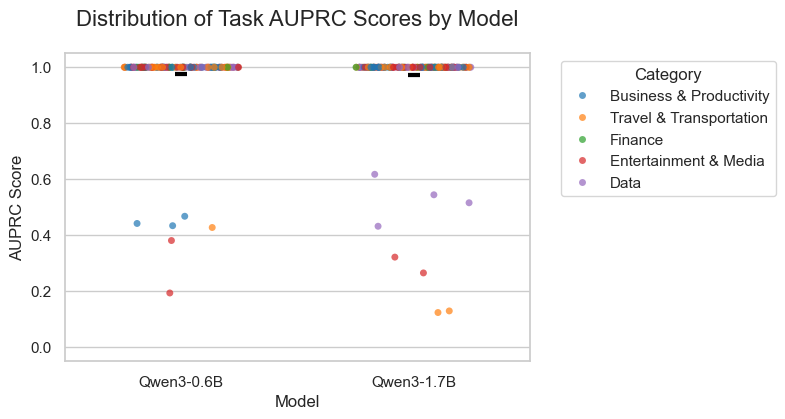

In [3]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import os
from datetime import datetime

# =============================================================================
# --- CONFIGURATION ---
# =============================================================================

DATA_FILEPATH = "../data/results_dataframe.parquet"
OUTPUT_DIR = "../visualization/plots"
PLOT_TITLE = "Distribution of Task AUPRC Scores by Model"

# --- Visual Settings ---
X_AXIS = 'model'          # Group by Model
Y_AXIS = 'auprc'          # The metric to plot
HUE = 'category'          # Color dots by Category

# --- Plot Dimensions ---
FIG_WIDTH = 6   
FIG_HEIGHT = 4  

CATEGORY_DISPLAY_NAMES = {
    'business_and_productivity': 'Business & Productivity',
    'data': 'Data',
    'entertainment_and_media': 'Entertainment & Media',
    'finance': 'Finance',
    'travel_and_transportation': 'Travel & Transportation',
}

# =============================================================================
# --- SCRIPT ---
# =============================================================================

def plot_auprc_distribution():
    # 1. Load Data
    if not os.path.exists(DATA_FILEPATH):
        print(f"Error: File not found at {DATA_FILEPATH}")
        return

    print(f"Loading data from {DATA_FILEPATH}...")
    try:
        df = pd.read_parquet(DATA_FILEPATH)
    except Exception as e:
        print(f"Error loading parquet: {e}")
        return

    # 2. Preprocessing
    # Filter for rows that actually have an AUPRC score
    df_clean = df.dropna(subset=[Y_AXIS]).copy()
    
    # Deduplicate: One row per task
    if 'task_model_id' in df_clean.columns:
        df_unique = df_clean.drop_duplicates(subset=['task_model_id']).copy()
    else:
        df_unique = df_clean.drop_duplicates(subset=['task_id', 'model']).copy()
    
    # --- APPLY NAME MAPPING ---
    if HUE == 'category' and 'category' in df_unique.columns:
        print("Mapping category names...")
        df_unique['category'] = df_unique['category'].map(CATEGORY_DISPLAY_NAMES).fillna(df_unique['category'])

    print(f"Plotting {len(df_unique)} unique tasks...")

    # 3. Setup Plot with Custom Dimensions
    sns.set_theme(style="whitegrid")
    plt.figure(figsize=(FIG_WIDTH, FIG_HEIGHT))

    # 4. Create Jitter Plot (Strip Plot)
    ax = sns.stripplot(
        data=df_unique,
        x=X_AXIS,
        y=Y_AXIS,
        hue=HUE,
        jitter=0.25,      
        size=5,           
        alpha=0.7,        
        palette="tab10",  
        dodge=False       
    )

    # 5. Add Mean Line
    sns.pointplot(
        data=df_unique, 
        x=X_AXIS, 
        y=Y_AXIS, 
        estimator='mean', 
        color='black', 
        markers="_", 
        scale=1.5, 
        errorbar=None,
        join=False
    )

    # 6. Formatting
    plt.title(PLOT_TITLE, fontsize=16, pad=20)
    plt.xlabel("Model", fontsize=12)
    plt.ylabel("AUPRC Score", fontsize=12)
    plt.ylim(-0.05, 1.05) 
    
    # Legend placement
    if HUE:
        plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', title="Category")

    # 7. Save
    timestamp = datetime.now().strftime("%d%m_%H%M%S")
    os.makedirs(OUTPUT_DIR, exist_ok=True)
    
    filename = f"auprc_distribution_{timestamp}"
    
    # Save PNG (Raster)
    plt.savefig(os.path.join(OUTPUT_DIR, f"{filename}.png"), bbox_inches='tight', dpi=300)
    
    print(f"✅ Plot saved to {OUTPUT_DIR}/{filename}.png")
    print(f"   Dimensions: {FIG_WIDTH}x{FIG_HEIGHT} inches")

if __name__ == "__main__":
    plot_auprc_distribution()

Span Metrics Table Visualization
--------------------------

In [4]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import os
import re
from datetime import datetime

# =============================================================================
# --- 1. YOUR MANUAL CONTROL PANEL (Set everything here) ---
# =============================================================================

# --- A. Data Settings ---
DATA_FILEPATH = "../data/results_dataframe.parquet"
VIS_OUTPUT_DIR = "../visualization/tables"

# --- B. Visualization Mode ---
METRIC_TYPE = 'nad' # select aggregation metric 'attribution_density' 
TASK_FILTER = 'all' # Options: 'all', 'plan_correct', 'use_correct', 'both_incorrect'
MODEL_FILTER = 'all'

# --- C. Rows (Spans) to Display ---
SPANS_TO_DISPLAY = [
    'agentic_behaviour_instructions',
    'few_shot_examples',
    'functions_intro',
    'correct_function',
    'decoy_functions',
    'final_answer_tool',
    'general_code_use_rules',
    'call_to_action',
    'user_prompt',
    'planning_step'
]

# --- D. Naming & Aesthetics ---
TABLE_TITLE_BASE = "Average Normalized Attribution Density"

SPAN_DISPLAY_NAMES = {
    'agentic_behaviour_instructions': 'General Agentic Behavior ',
    'few_shot_examples': 'Few-shot Examples',
    'functions_intro': 'Tool Introduction',
    'correct_function': 'Correct Tool',
    'decoy_functions': 'Decoy Tools',
    'final_answer_tool': 'Final Answer Tool',
    'general_code_use_rules': 'Code Use Rules',
    'call_to_action': 'Call to Action',
    'user_prompt': 'User Prompt',
    'planning_step': 'Planning Step'
}

COLUMN_LABELS = ["Plan", "Action"] 

# --- E. Visual Styling ---
SNS_STYLE = 'white'
COLORMAP = 'Blues' 
NUMBER_FORMAT = ".3f" 
FIG_WIDTH = 5
FIG_HEIGHT = 6
CELL_BORDER_WIDTH = 0.5
CMAP_MIN = 0
CMAP_MAX = 0.5

# =============================================================================
# --- 2. DATA PROCESSING ---
# =============================================================================

def load_and_filter_data(filepath, model_filter, task_filter):
    """
    Loads data and applies the Model and Task filters.
    """
    if not os.path.exists(filepath):
        print(f"Error: File not found at {filepath}")
        return None

    print(f"Loading data...")
    df = pd.read_parquet(filepath)
    
    # 1. Filter by Model
    if model_filter != 'all':
        print(f"Filtering for Model: {model_filter}")
        df = df[df['model'] == model_filter].copy()
    
    # 2. Filter by Task Correctness
    plan_col = 'tool_plan_correct' if 'tool_plan_correct' in df.columns else 'plan_correct'
    use_col = 'tool_use_correct'


    if task_filter == 'plan_correct':
        print("Filtering for: Plan Correct == True")
        if plan_col in df.columns:
            df = df[df[plan_col] == True].copy()
        else:
            print("Warning: Plan correctness column not found.")

    elif task_filter == 'use_correct':
        print("Filtering for: Tool Use Correct == True")
        if use_col in df.columns:
            df = df[df[use_col] == True].copy()
        else:
            print("Warning: Tool use correctness column not found.")
    
    elif task_filter == 'both_incorrect':
        print("Filtering for: Plan == False AND Use == False (Double Failure)")
        if plan_col in df.columns and use_col in df.columns:
            # Keep rows where BOTH are False (0)
            df = df[ (df[plan_col] == False) & (df[use_col] == False) ].copy()
        else:
            print(f"Warning: Columns '{plan_col}' or '{use_col}' not found.")
            
    return df

def compute_metric_table(df, metric_base, spans):
    """
    Computes the average table for the given metric family.
    """
    if metric_base == 'sum':
        col_plan = 'sum_plan_attr'
        col_action = 'sum_action_attr'
    elif metric_base == 'mean':
        col_plan = 'mean_plan_attr'
        col_action = 'mean_action_attr'
    else:
        col_plan = f"{metric_base}_plan"
        col_action = f"{metric_base}_action"
        
    cols_to_fetch = [col_plan, col_action]
    
    missing = [c for c in cols_to_fetch if c not in df.columns]
    if missing:
        raise ValueError(f"Columns not found in dataframe: {missing}. Check your METRIC_TYPE.")

    df_filtered = df[df['span_name'].isin(spans)].copy()
    table = df_filtered.groupby('span_name')[cols_to_fetch].mean()
    table = table.reindex(spans)
    table.columns = COLUMN_LABELS
    
    if 'planning_step' in table.index:
        table.loc['planning_step', COLUMN_LABELS[0]] = np.nan
        
    return table

# =============================================================================
# --- 3. VISUALIZATION ---
# =============================================================================

def plot_heatmap(table):
    print("Generating Heatmap...")
    
    display_table = table.rename(index=SPAN_DISPLAY_NAMES)
    
    sns.set_theme(style=SNS_STYLE)
    plt.figure(figsize=(FIG_WIDTH, FIG_HEIGHT))
    
    title_str = f"{TABLE_TITLE_BASE}\n({METRIC_TYPE.upper()})"
    subtitle_str = f"Model: {MODEL_FILTER} | Task: {TASK_FILTER}"
    
    # Create Heatmap with manual vmin/vmax
    ax = sns.heatmap(
        display_table,
        annot=True,
        fmt=NUMBER_FORMAT,
        cmap=COLORMAP,
        linewidths=CELL_BORDER_WIDTH,
        linecolor='lightgray',
        square=False,
        vmin=CMAP_MIN,
        vmax=CMAP_MAX,
        cbar_kws={'label': f'Avg NAD(s)'}#{METRIC_TYPE}'}
    )
    
    plt.title(f"{title_str}\n{subtitle_str}", fontsize=12, pad=15)
    plt.ylabel("Sequence Spans", fontsize=10)
    plt.xlabel("Attribution Target", fontsize=10)
    
    plt.xticks(rotation=0)
    plt.yticks(rotation=0)

    timestamp = datetime.now().strftime("%d%m_%H%M%S")
    filename = f"{METRIC_TYPE}_{MODEL_FILTER}_{TASK_FILTER}_{timestamp}"
    
    os.makedirs(VIS_OUTPUT_DIR, exist_ok=True)
    out_png = os.path.join(VIS_OUTPUT_DIR, f"{filename}.png")
    
    plt.savefig(out_png, bbox_inches='tight', dpi=300)
    plt.close()
    
    print(f"✅ Saved to: {out_png}")

# =============================================================================
# --- MAIN ---
# =============================================================================

if __name__ == "__main__":
    
    df_main = load_and_filter_data(DATA_FILEPATH, MODEL_FILTER, TASK_FILTER)
    
    if df_main is not None and not df_main.empty:
        try:
            metric_table = compute_metric_table(
                df_main, 
                METRIC_TYPE, 
                SPANS_TO_DISPLAY
            )
            plot_heatmap(metric_table)
            
        except ValueError as e:
            print(f"Error: {e}")
            print("Tip: Check if the 'nad_plan' and 'nad_action' columns exist in your parquet file.")
    else:
        print("Dataframe is empty after filtering or could not be loaded.")

Loading data...
Generating Heatmap...
✅ Saved to: ../visualization/tables/nad_all_all_1612_014828.png


Compute and Plot Span Separation Metrics
------------------------

One Span, Distributions Plot

In [6]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import os
from datetime import datetime

# =============================================================================
# --- 1. CONFIGURATION ---
# =============================================================================

DATA_FILEPATH = "../data/results_dataframe.parquet"
VIS_OUTPUT_DIR = "../visualization/plots"

# Comparison Settings
TARGET_SPAN = "correct_function"
METRIC_BASE = "nad"
MODEL_FILTER = 'all'

# Visual Settings
FIG_WIDTH = 10
FIG_HEIGHT = 5.0
COLORS = {
    "Success": "#2ca02c",           # Green
    "Failure (All)": "#d62728",     # Red
    "Failure (Plan True)": "#ff7f0e" # Orange
}

# =============================================================================
# --- 2. HELPER FUNCTIONS ---
# =============================================================================

def calculate_cohens_d(group1, group2):
    """
    Calculates Cohen's d: (mean1 - mean2) / pooled_std
    """
    if len(group1) < 2 or len(group2) < 2:
        return np.nan

    mean1, mean2 = np.mean(group1), np.mean(group2)
    var1, var2 = np.var(group1, ddof=1), np.var(group2, ddof=1)
    n1, n2 = len(group1), len(group2)

    pooled_std = np.sqrt(((n1 - 1) * var1 + (n2 - 1) * var2) / (n1 + n2 - 2))
    
    if pooled_std == 0:
        return 0.0

    return (mean1 - mean2) / pooled_std

def add_stat_annotation(ax, mean1, mean2, d_val, y_pos, color):
    """
    Draws a double-headed arrow between mean1 and mean2 at height y_pos,
    and places a label box with Cohen's d in the center.
    """
    # 1. Draw the Double-Headed Arrow
    ax.annotate(
        '', 
        xy=(mean1, y_pos), xycoords='data',
        xytext=(mean2, y_pos), textcoords='data',
        arrowprops=dict(arrowstyle='<->', color='black', lw=1.5, shrinkA=0, shrinkB=0)
    )
    
    # 2. Add the Text Label (Centered)
    center_x = (mean1 + mean2) / 2
    label_text = f"d = {abs(d_val):.2f}"
    
    ax.text(
        center_x, y_pos, label_text,
        ha='center', va='center',
        fontsize=10, fontweight='bold', color='black',
        bbox=dict(boxstyle="round,pad=0.3", fc="white", ec=color, alpha=1.0, lw=1.5)
    )

# =============================================================================
# --- 3. PLOTTING FUNCTION ---
# =============================================================================

def plot_three_groups(df, metric_type):
    """
    Generates KDE plot with Means, Vertical Lines, and Cohen's d arrows.
    """
    metric_col = f"{METRIC_BASE}_{metric_type}"
    
    if metric_col not in df.columns:
        print(f"Skipping {metric_type}: Column '{metric_col}' not found.")
        return

    # --- Define Groups ---
    # 1. Success
    data_success = df[df['tool_use_correct'] == True][metric_col].dropna()

    # 2. Failure (General)
    data_fail_all = df[df['tool_use_correct'] == False][metric_col].dropna()

    # 3. Failure (Specific: Plan Correct but Use False)
    mask_fail_specific = (
        (df['tool_plan_correct'] == True) & 
        (df['tool_use_correct'] == False)
    )
    data_fail_specific = df[mask_fail_specific][metric_col].dropna()

    # --- Check Data ---
    if len(data_success) < 2 or len(data_fail_all) < 2:
        print("Not enough data to plot.")
        return

    # --- Calculate Statistics ---
    mean_success = np.mean(data_success)
    mean_fail_all = np.mean(data_fail_all)
    d_fail_all = calculate_cohens_d(data_fail_all, data_success)

    # Optional: Plan True Stats
    has_specific = len(data_fail_specific) > 1
    if has_specific:
        mean_fail_specific = np.mean(data_fail_specific)
        d_fail_specific = calculate_cohens_d(data_fail_specific, data_success)

    # --- Plotting ---
    sns.set_theme(style="whitegrid")
    fig, ax = plt.subplots(figsize=(FIG_WIDTH, FIG_HEIGHT))
    
    # 1. KDE Plots
    sns.kdeplot(data_success, fill=True, color=COLORS["Success"], label=f"Success (Mean={mean_success:.2f})", alpha=0.2, linewidth=2, ax=ax)
    sns.kdeplot(data_fail_all, fill=True, color=COLORS["Failure (All)"], label=f"Fail: All (Mean={mean_fail_all:.2f})", alpha=0.1, linestyle="--", linewidth=2, ax=ax)
    
    if has_specific:
        sns.kdeplot(data_fail_specific, fill=False, color=COLORS["Failure (Plan True)"], label=f"Fail: Plan True (Mean={mean_fail_specific:.2f})", linewidth=2.5, ax=ax)

    # --- Visual Setup for Annotations ---
    # Get current Y-limit to calculate heights dynamically
    y_min, y_max = ax.get_ylim()
    
    # 2. Draw Vertical Lines for Means
    # Success Line
    ax.vlines(mean_success, ymin=0, ymax=y_max*0.95, color=COLORS["Success"], linestyle='--', alpha=0.8)
    
    # Fail All Line
    ax.vlines(mean_fail_all, ymin=0, ymax=y_max*0.65, color=COLORS["Failure (All)"], linestyle='--', alpha=0.8)

    # Fail Specific Line
    if has_specific:
        ax.vlines(mean_fail_specific, ymin=0, ymax=y_max*0.85, color=COLORS["Failure (Plan True)"], linestyle='--', alpha=0.8)

    # 3. Draw Arrows and Labels (Stacked to avoid overlap)
    
    # Comparison 1: Success vs Fail (All)
    add_stat_annotation(
        ax, mean_success, mean_fail_all, d_fail_all, 
        y_pos=y_max * 0.5, 
        color=COLORS["Failure (All)"]
    )

    # Comparison 2: Success vs Fail 
    if has_specific:
        add_stat_annotation(
            ax, mean_success, mean_fail_specific, d_fail_specific, 
            y_pos=y_max * 0.7, 
            color=COLORS["Failure (Plan True)"]
        )

    plt.title(f"Separation of '{TARGET_SPAN}' ({metric_type.capitalize()})\nSuccess vs Failure Modes", fontsize=14)
    plt.xlabel(f"{METRIC_BASE.upper()}_{metric_type} Value", fontsize=11)
    plt.ylabel("Density", fontsize=11)
    
    # Move legend 
    plt.legend(loc='upper right', frameon=True, framealpha=0.95)
    
    # Save
    timestamp = datetime.now().strftime("%d%m_%H%M")
    os.makedirs(VIS_OUTPUT_DIR, exist_ok=True)
    out_path = os.path.join(VIS_OUTPUT_DIR, f"3groups_arrow_{TARGET_SPAN}_{metric_type}_{timestamp}.png")
    
    plt.savefig(out_path, dpi=300, bbox_inches='tight')
    plt.close()
    print(f"✅ Saved: {out_path}")

# =============================================================================
# --- 4. MAIN ---
# =============================================================================

if __name__ == "__main__":
    if not os.path.exists(DATA_FILEPATH):
        print(f"Error: File not found at {DATA_FILEPATH}")
        exit()
        
    print(f"Loading data from {DATA_FILEPATH}...")
    df = pd.read_parquet(DATA_FILEPATH)

    df_span = df[df['span_name'] == TARGET_SPAN].copy()
    if MODEL_FILTER != 'all':
        df_span = df_span[df_span['model'] == MODEL_FILTER]

    plot_three_groups(df_span, metric_type="plan")
    plot_three_groups(df_span, metric_type="action")

Loading data from ../data/results_dataframe.parquet...
✅ Saved: ../visualization/plots/3groups_arrow_correct_function_plan_1612_0149.png
✅ Saved: ../visualization/plots/3groups_arrow_correct_function_action_1612_0149.png


All Spans Table

In [8]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import os
from datetime import datetime
from scipy import stats
from sklearn.metrics import roc_auc_score

# =============================================================================
# --- 1. CONFIGURATION ---
# =============================================================================

# --- A. Data Settings ---
DATA_FILEPATH = "../data/results_dataframe.parquet"
VIS_OUTPUT_DIR = "../visualization/tables"

# --- B. Metric Settings ---
METRIC_BASE = 'nad'  # e.g., 'nad' -> looks for 'nad_plan' and 'nad_action'
MODEL_FILTER = 'all' # Options: 'all', 'Qwen3-1.7B', 'Qwen3-0.6B'

# --- C. Comparison Mode ---
# Select the mode (1-4) to define Group A vs Group B
# Mode 1: Success vs Failure
# Mode 2: Plan Correct vs Plan Incorrect
# Mode 3: Reasoning Error (Plan True, Use False) vs Success
# Mode 4: Pure Reasoning Error (No Loop) vs Loop/Hallucination Failure

COMPARISON_MODE = 1

if COMPARISON_MODE == 1:
    # 1. tool_use_correct = True; vs = False.
    GROUP_A_NAME = "Success (Tool Use Correct)"
    GROUP_A_QUERY = "tool_use_correct == True"
    GROUP_B_NAME = "Failure (Tool Use Incorrect)"
    GROUP_B_QUERY = "tool_use_correct == False"
    MODE_TAG = "mode1_success_vs_fail"

elif COMPARISON_MODE == 2:
    # 2. tool_plan_correct = True; vs = False.
    GROUP_A_NAME = "Plan Correct"
    GROUP_A_QUERY = "tool_plan_correct == True"
    GROUP_B_NAME = "Plan Incorrect"
    GROUP_B_QUERY = "tool_plan_correct == False"
    MODE_TAG = "mode2_plan_correct_vs_incorrect"

elif COMPARISON_MODE == 3:
    # 3. Reasoning Success but use Error vs Use Success
    # (Plan Correct but Use Incorrect) vs (Success)
    GROUP_A_NAME = "Success (Use correct)"
    GROUP_A_QUERY = "tool_use_correct == True"
    GROUP_B_NAME = "Reasoning Error (Plan correct, Use incorrect)"
    GROUP_B_QUERY = "tool_plan_correct == True and tool_use_correct == False"
    MODE_TAG = "mode3_success_vs_reasoning_without_use"

elif COMPARISON_MODE == 4:
    # 4. Pure Reasoning Error vs Loop/Hallucination
    # (Plan True, Use False, No Loop) vs (Loop/Hal True)
    GROUP_A_NAME = "Reasoning Error (No Loop)"
    GROUP_A_QUERY = "tool_plan_correct == True and tool_use_correct == False and loop_hal_fail == False"
    GROUP_B_NAME = "Loop/Hallucination Fail"
    GROUP_B_QUERY = "loop_hal_fail == True"
    MODE_TAG = "mode4_reasoning_vs_loop_hal"

elif COMPARISON_MODE == 5:
    # 5. Reasoning Success vs Loop/Hallucination
    # (Plan True including loop)) vs (Loop/Hal True)
    GROUP_A_NAME = "Plan Correct"
    GROUP_A_QUERY = "tool_plan_correct == True"
    GROUP_B_NAME = "Loop/Hallucination Fail"
    GROUP_B_QUERY = "loop_hal_fail == True"
    MODE_TAG = "mode5_reasoning_vs_loop_hal"

else:
    raise ValueError("Invalid COMPARISON_MODE. Choose 1, 2, 3, or 4.")

# --- D. Rows (Spans) to Display ---
SPANS_TO_DISPLAY = [
    'agentic_behaviour_instructions',
    'few_shot_examples',
    'functions_intro',
    'correct_function',
    'decoy_functions',
    'final_answer_tool',
    'general_code_use_rules',
    'call_to_action',
    'user_prompt',
    'planning_step'
]

SPAN_DISPLAY_NAMES = {
    'agentic_behaviour_instructions': 'General Agentic Behavior',
    'few_shot_examples': 'Few-shot Examples',
    'functions_intro': 'Tool Introduction',
    'correct_function': 'Correct Tool',
    'decoy_functions': 'Decoy Tools',
    'final_answer_tool': 'Final Answer Tool',
    'general_code_use_rules': 'Code Use Rules',
    'call_to_action': 'Call to Action',
    'user_prompt': 'User Prompt',
    'planning_step': 'Planning Step'
}

COLUMN_LABELS = ["Plan", "Action"] 

# --- E. Visual Styling ---
FIG_WIDTH = 4.5
FIG_HEIGHT = 6.5
CELL_BORDER_WIDTH = 0.5

# =============================================================================
# --- 2. CALCULATIONS ---
# =============================================================================

def calculate_cohens_d(group_a, group_b):
    """
    Computes Cohen's d.
    Positive value: Group A > Group B
    Negative value: Group B > Group A
    """
    if len(group_a) < 2 or len(group_b) < 2:
        return np.nan

    diff = np.mean(group_a) - np.mean(group_b)
    var_a = np.var(group_a, ddof=1)
    var_b = np.var(group_b, ddof=1)
    
    # Pooled Standard Deviation
    n_a, n_b = len(group_a), len(group_b)
    pooled_var = ((n_a - 1) * var_a + (n_b - 1) * var_b) / (n_a + n_b - 2)
    pooled_std = np.sqrt(pooled_var)
    
    if pooled_std == 0:
        return 0.0
        
    return diff / pooled_std

def calculate_auc(group_a, group_b):
    """
    Computes ROC-AUC.
    Returns RAW score (0.0 to 1.0).
    1.0 = Perfect Positive Separation (A > B)
    0.5 = Random
    0.0 = Perfect Inverted Separation (B > A)
    """
    if len(group_a) < 1 or len(group_b) < 1:
        return np.nan
        
    y_true = [1] * len(group_a) + [0] * len(group_b)
    y_scores = list(group_a) + list(group_b)
    
    try:
        score = roc_auc_score(y_true, y_scores)
        return score
    except ValueError:
        return 0.5

def compute_separation_matrices(df):
    """
    Generates two DataFrames: one for Cohen's d, one for AUC.
    """
    # 1. Apply Model Filter
    if MODEL_FILTER != 'all':
        print(f"Filtering data for model: {MODEL_FILTER}")
        df = df[df['model'] == MODEL_FILTER].copy()
    else:
        print("Using data from ALL models.")

    # 2. Split Data using the configured queries
    try:
        df_a = df.query(GROUP_A_QUERY)
        df_b = df.query(GROUP_B_QUERY)
    except Exception as e:
        print(f"Error executing query. Check column names (e.g., 'loop_hal_fail').\nQuery A: {GROUP_A_QUERY}\nQuery B: {GROUP_B_QUERY}")
        raise e
    
    print(f"\n--- Comparison Mode {COMPARISON_MODE} ---")
    print(f"Group A ({GROUP_A_NAME}): {len(df_a)} rows")
    print(f"Group B ({GROUP_B_NAME}): {len(df_b)} rows")
    
    if len(df_a) == 0 or len(df_b) == 0:
        print("WARNING: One of the groups is empty. Check your filters.")

    # 3. Define Columns to look for
    col_plan = f"{METRIC_BASE}_plan"
    col_action = f"{METRIC_BASE}_action"
    
    metrics_map = {'Plan': col_plan, 'Action': col_action}
    
    # 4. Initialize Results Containers
    d_matrix = pd.DataFrame(index=SPANS_TO_DISPLAY, columns=['Plan', 'Action'])
    auc_matrix = pd.DataFrame(index=SPANS_TO_DISPLAY, columns=['Plan', 'Action'])
    
    # 5. Loop and Compute
    for span in SPANS_TO_DISPLAY:
        # Filter for this specific span
        span_a = df_a[df_a['span_name'] == span]
        span_b = df_b[df_b['span_name'] == span]
        
        for col_name, metric_col in metrics_map.items():
            
            # Extract valid values (drop NaNs)
            vals_a = span_a[metric_col].dropna().values
            vals_b = span_b[metric_col].dropna().values
            
            # Compute Stats
            d_val = calculate_cohens_d(vals_a, vals_b)
            auc_val = calculate_auc(vals_a, vals_b)
            
            # Store
            d_matrix.loc[span, col_name] = d_val
            auc_matrix.loc[span, col_name] = auc_val

    # 6. Clean up types
    d_matrix = d_matrix.astype(float)
    auc_matrix = auc_matrix.astype(float)
    
    # 7. Formatting for Planning Step
    if 'planning_step' in d_matrix.index:
        d_matrix.loc['planning_step', 'Plan'] = np.nan
        auc_matrix.loc['planning_step', 'Plan'] = np.nan
        
    return d_matrix, auc_matrix

# =============================================================================
# --- 3. VISUALIZATION ---
# =============================================================================

def plot_single_heatmap(data, title, cbar_label, cmap, vmin, vmax, center=None, filename_suffix=""):
    
    display_data = data.rename(index=SPAN_DISPLAY_NAMES)
    
    sns.set_theme(style='white')
    plt.figure(figsize=(FIG_WIDTH, FIG_HEIGHT))
    
    ax = sns.heatmap(
        display_data,
        annot=True,
        fmt=".2f",
        cmap=cmap,
        linewidths=CELL_BORDER_WIDTH,
        linecolor='lightgray',
        square=False,
        vmin=vmin,
        vmax=vmax,
        center=center, 
        cbar_kws={'label': cbar_label}
    )
    
    plt.title(f"{title}\n{GROUP_A_NAME} vs. {GROUP_B_NAME}\nModel: {MODEL_FILTER}", fontsize=10, pad=15)
    plt.ylabel("Sequence Spans", fontsize=10)
    plt.xlabel("Attribution Target", fontsize=10)
    
    # Save
    timestamp = datetime.now().strftime("%d%m_%H%M")
    os.makedirs(VIS_OUTPUT_DIR, exist_ok=True)
    
    out_path = os.path.join(VIS_OUTPUT_DIR, f"{METRIC_BASE}_{MODE_TAG}_{MODEL_FILTER}_{filename_suffix}_{timestamp}.png")
    
    plt.savefig(out_path, bbox_inches='tight', dpi=300)
    plt.close()
    print(f"✅ Saved plot: {out_path}")

# =============================================================================
# --- MAIN ---
# =============================================================================

if __name__ == "__main__":
    
    if not os.path.exists(DATA_FILEPATH):
        print(f"Error: File not found at {DATA_FILEPATH}")
        exit()

    print("Loading data...")
    df = pd.read_parquet(DATA_FILEPATH)
    
    # Compute
    try:
        d_mat, auc_mat = compute_separation_matrices(df)
        
        # --- Plot 1: Cohen's d  ---
        plot_single_heatmap(
            d_mat,
            title=f"Effect Size (Cohen's d)\nMetric: {METRIC_BASE.upper()}",
            cbar_label="Cohen's d(s)",
            cmap="RdBu_r", 
            vmin=-2.0,     
            vmax=2.0,
            center=0,      
            filename_suffix="cohens_d"
        )
        
        # --- Plot 2: ROC-AUC  ---
        plot_single_heatmap(
            auc_mat,
            title=f"Discriminative Power (AUC)\nMetric: {METRIC_BASE.upper()}",
            cbar_label="ROC-AUC(s)",
            cmap="RdBu_r", 
            vmin=0.0, 
            vmax=1.0, 
            center=0.5,
            filename_suffix="roc_auc"
        )
        
    except Exception as e:
        print(f"An error occurred: {e}")
        import traceback
        traceback.print_exc()

Loading data...
Using data from ALL models.

--- Comparison Mode 1 ---
Group A (Success (Tool Use Correct)): 3597 rows
Group B (Failure (Tool Use Incorrect)): 1507 rows
✅ Saved plot: ../visualization/tables/nad_mode1_success_vs_fail_all_cohens_d_1612_0150.png
✅ Saved plot: ../visualization/tables/nad_mode1_success_vs_fail_all_roc_auc_1612_0150.png


Compute and Plot Correlation of Task Success and aggregated Attribution Metric
------------

Distribution Plot

In [9]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import numpy as np
import os
import re
from datetime import datetime
from scipy import stats

# =============================================================================
# --- CONFIGURATION ---
# =============================================================================

DATA_FILEPATH = "../data/results_dataframe.parquet"
OUTPUT_DIR = "../visualization/plots"

# Metric Settings
METRIC_COL = 'nad_plan'
PLOT_TITLE = "Success Rate vs. NAD (Plan) on Correct Tool"

# --- OUTLIER HANDLING ---
# Set to 0.0 to keep everything. 
# Set to 0.025 to remove the top 2.5% and bottom 2.5% (Total 5%)
REMOVE_OUTLIERS_QUANTILE = 0.00 

# Visual Settings
SNS_STYLE = "whitegrid"
FIG_WIDTH = 10
FIG_HEIGHT = 6

def prepare_task_data(filepath):
    print(f"Loading data from: {filepath}")
    if not os.path.exists(filepath):
        raise FileNotFoundError(f"File not found: {filepath}")
        
    df = pd.read_parquet(filepath)

    # Validation
    if 'task' not in df.columns:
        raise ValueError("The column 'task' is missing from the dataframe.")
    if METRIC_COL not in df.columns:
        raise ValueError(f"The metric column '{METRIC_COL}' is missing. Please run the NAD computation script first.")

    print("Filtering for Correct Function spans...")
    target_spans = ['correct_function']
    subset = df[df['span_name'].isin(target_spans)].copy()
    
    if subset.empty:
        raise ValueError("No 'correct_function' spans found in the dataframe.")

    print(f"Aggregating {METRIC_COL} by Task...")
    
    # Determine correctness column
    correct_col = 'tool_use_correct'
    
    task_stats = subset.groupby('task').agg(
        avg_density=(METRIC_COL, 'mean'),       
        correct_count=(correct_col, 'sum'),
        total_attempts=(correct_col, 'count') 
    ).reset_index()

    task_stats['pct_correct'] = (task_stats['correct_count'] / task_stats['total_attempts']) * 100

    if REMOVE_OUTLIERS_QUANTILE > 0:
        original_len = len(task_stats)
        lower = task_stats['avg_density'].quantile(REMOVE_OUTLIERS_QUANTILE)
        upper = task_stats['avg_density'].quantile(1 - REMOVE_OUTLIERS_QUANTILE)
        
        task_stats = task_stats[
            (task_stats['avg_density'] >= lower) & 
            (task_stats['avg_density'] <= upper)
        ]
        print(f"Removed outliers outside {lower:.4f} - {upper:.4f}. Count: {original_len} -> {len(task_stats)}")

    return task_stats

def create_scatter_plot(df):
    print("Generating Scatter Plot...")
    
    # --- CALCULATE STATISTICS (Pearson & Spearman) ---
    # Pearson: Standard linear correlation (sensitive to outliers)
    r_p, p_p = stats.pearsonr(df['pct_correct'], df['avg_density'])
    
    # Spearman: Rank correlation (Robust to outliers)
    r_s, p_s = stats.spearmanr(df['pct_correct'], df['avg_density'])
    
    stats_text = (
        f"Pearson r  = {r_p:.2f} (p={p_p:.1e})\n"
        f"Spearman r = {r_s:.2f} (p={p_s:.1e})"
    )
    print(f"\nSTATISTICS:\n{stats_text}\n")

    sns.set_theme(style=SNS_STYLE)
    plt.figure(figsize=(FIG_WIDTH, FIG_HEIGHT))
    
    # --- ADD JITTER ---
    rng = np.random.default_rng(42)
    noise = rng.uniform(-1.5, 1.5, size=len(df))
    df['pct_correct_jittered'] = df['pct_correct'] + noise
    
    # 1. Create Scatter Plot
    ax = sns.scatterplot(
        data=df,
        x='pct_correct_jittered', 
        y='avg_density',
        hue='pct_correct',
        palette='viridis',
        s=100,
        alpha=0.7,
        edgecolor='w',
        linewidth=0.5,
        zorder=2
    )
    
    # 2. ADD TREND LINE
    sns.regplot(
        data=df,
        x='pct_correct',
        y='avg_density',
        scatter=False,
        color='black',
        line_kws={'linewidth': 1.5, 'linestyle': '-.', 'alpha': 0.6, 'zorder': 1},
        ax=ax,
        truncate=False
    )
    
    plt.axhline(0, color='gray', linestyle='-', linewidth=1, alpha=0.3, zorder=0)

    # --- Labels & Titles ---
    title_suffix = f" (Outliers Removed: {REMOVE_OUTLIERS_QUANTILE*2:.0%})" if REMOVE_OUTLIERS_QUANTILE > 0 else ""
    plt.title(PLOT_TITLE + title_suffix, fontsize=16, pad=20)
    plt.xlabel("Task Success Rate (%)", fontsize=12)
    plt.ylabel(f"Avg {METRIC_COL} (Correct Function)", fontsize=12)
    
    plt.xlim(-5, 105)
    ax.xaxis.set_major_formatter(mtick.PercentFormatter(decimals=0))
    
    plt.legend(title="Success %", bbox_to_anchor=(1.02, 0.5), loc='center left')

    # --- ADD STATS BOX ---
    plt.text(
        0.05, 0.95, 
        stats_text, 
        transform=ax.transAxes, 
        fontsize=10, 
        fontfamily='monospace',
        verticalalignment='top', 
        bbox=dict(boxstyle='round', facecolor='white', alpha=0.9)
    )

    # Annotate Top/Bottom outliers (if not filtered too heavily)
    if len(df) >= 6:
        # Sort by density
        top_3 = df.sort_values('avg_density', ascending=False).head(3)
        bottom_3 = df.sort_values('avg_density', ascending=True).head(3)
        
        def annotate_points(subset, color):
            for _, row in subset.iterrows():
                plt.text(
                    row['pct_correct_jittered'], 
                    row['avg_density'], 
                    f"  {row['task'][:15]}...", 
                    fontsize=8, 
                    color=color, 
                    va='center',
                    weight='bold'
                )

        annotate_points(top_3, 'green')

    # --- Save ---
    timestamp = datetime.now().strftime("%d%m_%H%M%S")
    filter_tag = "_FILTERED" if REMOVE_OUTLIERS_QUANTILE > 0 else ""
    filename_base = f"Scatter_NAD_Success_{filter_tag}_{timestamp}"
    
    os.makedirs(OUTPUT_DIR, exist_ok=True)
    png_path = os.path.join(OUTPUT_DIR, f"{filename_base}.png")
    
    plt.savefig(png_path, bbox_inches='tight', dpi=300)
    plt.close()
    
    print(f"\n✅ Saved Scatter Plot: {png_path}")

if __name__ == "__main__":
    try:
        task_data = prepare_task_data(DATA_FILEPATH)
        print(f"Processed {len(task_data)} unique tasks.")
        create_scatter_plot(task_data)
    except Exception as e:
        print(f"Error: {e}")
        import traceback
        traceback.print_exc()

Loading data from: ../data/results_dataframe.parquet
Filtering for Correct Function spans...
Aggregating nad_plan by Task...
Processed 94 unique tasks.
Generating Scatter Plot...

STATISTICS:
Pearson r  = 0.57 (p=2.0e-09)
Spearman r = 0.55 (p=1.1e-08)


✅ Saved Scatter Plot: ../visualization/plots/Scatter_NAD_Success__1612_015137.png


All Spans Table

In [10]:
import pandas as pd
import numpy as np
import os
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
from datetime import datetime

# =============================================================================
# --- CONFIGURATION ---
# =============================================================================

DATA_FILEPATH = "../data/results_dataframe.parquet"
OUTPUT_DIR = "../visualization/tables"
IGNORE_SPANS = ['action_step', 'planning_step']

# Naming Convention
SPAN_DISPLAY_NAMES = {
    'user_prompt': 'User Prompt',
    'correct_function': 'Correct Tool',
    'decoy_functions': 'Decoy Tools',
    'agentic_behaviour_instructions' : 'General agentic behavior',
    'few_shot_examples': 'Few-shot examples',
    'functions_intro': 'Tool introduction',
    'final_answer_tool': 'Final Answer Tool',
    'general_code_use_rules': 'Code use rules',
    'call_to_action': 'Call to action'
}

def get_stars(p):
    """Returns significance stars."""
    return '***' if p < 0.001 else ('**' if p < 0.01 else ('*' if p < 0.05 else ''))

def calc_correlations(df_subset, label):
    """
    Helper: Calculates stats for a dataframe subset.
    Returns a dictionary with keys prefixed by 'label'.
    """
    if len(df_subset) < 5:
        return {
            f'{label} Pearson r': np.nan, f'{label} Pearson p': np.nan, f'{label} Pearson Sig': '',
            f'{label} Spearman r': np.nan, f'{label} Spearman p': np.nan, f'{label} Spearman Sig': ''
        }

    # Aggregate by Task (Success Rate vs Avg Density)
    task_stats = df_subset.groupby('task').agg(
        avg_density=('attribution_density_plan', 'mean'), 
        correct_count=('is_correct', 'sum'),
        total_attempts=('is_correct', 'count') 
    ).reset_index()

    task_stats['pct_correct'] = (task_stats['correct_count'] / task_stats['total_attempts']) * 100

    # Variance Check
    if task_stats['pct_correct'].nunique() <= 1 or task_stats['avg_density'].nunique() <= 1:
        return {
            f'{label} Pearson r': np.nan, f'{label} Pearson p': np.nan, f'{label} Pearson Sig': '',
            f'{label} Spearman r': np.nan, f'{label} Spearman p': np.nan, f'{label} Spearman Sig': ''
        }

    # Calculate Stats
    r_p, p_p = stats.pearsonr(task_stats['pct_correct'], task_stats['avg_density'])
    r_s, p_s = stats.spearmanr(task_stats['pct_correct'], task_stats['avg_density'])

    return {
        f'{label} Pearson r': r_p,
        f'{label} Pearson p': p_p,
        f'{label} Pearson Sig': get_stars(p_p),
        f'{label} Spearman r': r_s,
        f'{label} Spearman p': p_s,
        f'{label} Spearman Sig': get_stars(p_s)
    }

def generate_table():
    print(f"Loading data from: {DATA_FILEPATH}")
    if not os.path.exists(DATA_FILEPATH):
        print("Error: File not found.")
        return

    df = pd.read_parquet(DATA_FILEPATH)
    
    # Identify Models
    models = sorted(df['model'].unique())
    print(f"Found Models: {models}")
    
    # Identify Spans
    all_spans = df['span_name'].unique()
    valid_spans = [s for s in all_spans if s not in IGNORE_SPANS]
    
    results = []
    print(f"Analyzing {len(valid_spans)} spans across {len(models) + 1} groups (All + Individual Models)...")
    
    for span in valid_spans:
        span_df = df[df['span_name'] == span].copy()
        
        if span_df.empty:
            continue

        # 1. Base Info
        row_data = {'Span Name': span}
        
        # 2. All Models (Combined)
        stats_all = calc_correlations(span_df, "All")
        row_data.update(stats_all)
        
        # 3. Per Model Loop
        for model in models:
            model_df = span_df[span_df['model'] == model].copy()
            stats_model = calc_correlations(model_df, model)
            row_data.update(stats_model)
            
        results.append(row_data)

    # --- DATAFRAME CREATION ---
    results_df = pd.DataFrame(results)
    results_df['Display Name'] = results_df['Span Name'].map(SPAN_DISPLAY_NAMES).fillna(results_df['Span Name'])
    
    # Sort by "All Models" Pearson strength
    if 'All Pearson r' in results_df.columns:
        results_df['abs_r'] = results_df['All Pearson r'].abs()
        results_df = results_df.sort_values('abs_r', ascending=False).drop(columns=['abs_r'])

    # --- VISUALIZATION ---
    create_complex_heatmap(results_df, models)

def create_complex_heatmap(df, models):
    print("\nGenerating Model-Wise Heatmap...")
    
    # We need to construct the plot data carefully.
    # Columns should be:
    # [All Pearson, All Spearman, Model1 Pearson, Model1 Spearman, Model2 Pearson, Model2 Spearman...]
    
    # 1. Define Column Order
    cols_ordered = []
    labels_ordered = []
    
    # Group 1: All
    cols_ordered.extend(['All Pearson r', 'All Spearman r'])
    labels_ordered.extend(['All Models\n(Pearson)', 'All Models\n(Spearman)'])
    
    # Group 2..N: Models
    for m in models:
        cols_ordered.extend([f'{m} Pearson r', f'{m} Spearman r'])
        # Shorten model name for display if needed, e.g., remove "Qwen3-" if it's repetitive
        display_m = m.replace('Qwen3-', '') 
        labels_ordered.extend([f'{display_m}\n(Pearson)', f'{display_m}\n(Spearman)'])
        
    # 2. Prepare Plot Data
    plot_data = df.set_index('Display Name')[cols_ordered]
    
    # 3. Prepare Annotation Data (NO STARS)
    annot_data = plot_data.copy().astype(str)
    
    for idx, row in df.iterrows():
        name = row['Display Name']
        
        # All Models
        p_val = row['All Pearson r']
        if pd.notna(p_val):
            # Format: 0.50 (p=1.2e-05)
            annot_data.at[name, 'All Pearson r'] = f"{p_val:.2f} (p={row['All Pearson p']:.1e})"
        else:
            annot_data.at[name, 'All Pearson r'] = "N/A"

        s_val = row['All Spearman r']
        if pd.notna(s_val):
            annot_data.at[name, 'All Spearman r'] = f"{s_val:.2f} (p={row['All Spearman p']:.1e})"
        else:
            annot_data.at[name, 'All Spearman r'] = "N/A"
            
        # Specific Models
        for m in models:
            mp_col = f'{m} Pearson r'
            ms_col = f'{m} Spearman r'
            
            mp_val = row[mp_col]
            if pd.notna(mp_val):
                annot_data.at[name, mp_col] = f"{mp_val:.2f} (p={row[f'{m} Pearson p']:.1e})"
            else:
                annot_data.at[name, mp_col] = "N/A"
                
            ms_val = row[ms_col]
            if pd.notna(ms_val):
                annot_data.at[name, ms_col] = f"{ms_val:.2f} (p={row[f'{m} Spearman p']:.1e})"
            else:
                annot_data.at[name, ms_col] = "N/A"

    # --- PLOTTING ---
    sns.set_theme(style="white")
    
    # Dynamic Width: 4 inches base + 2.5 inches per group (All + Models)
    width = 4 + (2.5 * (len(models) + 1))
    
    # CHANGED HEIGHT: Reduced multiplier from 0.8 to 0.4 for compact cells
    height = len(df) * 0.4 + 2
    
    plt.figure(figsize=(width, height)) 
    
    ax = sns.heatmap(
        plot_data,
        annot=annot_data,
        fmt="",          
        cmap="coolwarm", 
        center=0,        
        vmin=-1, vmax=1, 
        linewidths=1,
        cbar_kws={"shrink": 0.5, "label": "Correlation Strength (r)"},
        annot_kws={"size": 9} 
    )
    
    plt.title("Predictive Power of Attribution Density by Model", fontsize=16, pad=20)
    plt.ylabel("")
    
    # Set custom x-axis labels
    ax.set_xticks(np.arange(len(labels_ordered)) + 0.5)
    ax.set_xticklabels(labels_ordered, rotation=0)
    plt.yticks(rotation=0)
    
    # Save
    timestamp = datetime.now().strftime("%d%m_%H%M%S")
    filename = f"Model_Wise_Correlations_{timestamp}.png"
    save_path = os.path.join(OUTPUT_DIR, filename)
    
    plt.savefig(save_path, bbox_inches='tight', dpi=300)
    plt.close()
    print(f"✅ Visualization saved to: {save_path}")

if __name__ == "__main__":
    generate_table()

Loading data from: ../data/results_dataframe.parquet
Found Models: ['Qwen3-0.6B', 'Qwen3-1.7B']
Analyzing 9 spans across 3 groups (All + Individual Models)...

Generating Model-Wise Heatmap...
✅ Visualization saved to: ../visualization/tables/Model_Wise_Correlations_1612_015151.png


Table Combined Spans

In [11]:
import pandas as pd
import numpy as np
import os
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
from datetime import datetime

# =============================================================================
# --- CONFIGURATION ---
# =============================================================================

DATA_FILEPATH = "../data/results_dataframe.parquet"
OUTPUT_DIR = "../visualization/tables"

# Definitions of Groups
GROUP_TOOL_SET = ['correct_function', 'decoy_functions']
IGNORE_SPANS = ['action_step', 'planning_step']

# Naming for the Heatmap
GROUP_DISPLAY_NAMES = {
    'Tool_Set': 'Custom Tool Set\n(Correct + Decoy)',
    'Context_Rest': 'Context & Instructions\n(Rest)'
}

def calc_correlations(df_subset, label):
    """
    Helper: Calculates stats for a dataframe subset.
    """
    if len(df_subset) < 5:
        return {
            f'{label} Pearson r': np.nan, f'{label} Pearson p': np.nan,
            f'{label} Spearman r': np.nan, f'{label} Spearman p': np.nan
        }

    # Aggregate by Task
    # We take the mean of the calculated AD for the task's runs
    task_stats = df_subset.groupby('task').agg(
        avg_density=('combined_ad', 'mean'), 
        correct_count=('is_correct', 'sum'),
        total_attempts=('is_correct', 'count') 
    ).reset_index()

    task_stats['pct_correct'] = (task_stats['correct_count'] / task_stats['total_attempts']) * 100

    if task_stats['pct_correct'].nunique() <= 1 or task_stats['avg_density'].nunique() <= 1:
        return {
            f'{label} Pearson r': np.nan, f'{label} Pearson p': np.nan,
            f'{label} Spearman r': np.nan, f'{label} Spearman p': np.nan
        }

    r_p, p_p = stats.pearsonr(task_stats['pct_correct'], task_stats['avg_density'])
    r_s, p_s = stats.spearmanr(task_stats['pct_correct'], task_stats['avg_density'])

    return {
        f'{label} Pearson r': r_p,
        f'{label} Pearson p': p_p,
        f'{label} Spearman r': r_s,
        f'{label} Spearman p': p_s
    }

def generate_combined_table():
    print(f"Loading data from: {DATA_FILEPATH}")
    if not os.path.exists(DATA_FILEPATH):
        print("Error: File not found.")
        return

    df = pd.read_parquet(DATA_FILEPATH)
    
    # 1. Filter Data
    # Remove spans we don't want at all
    df = df[~df['span_name'].isin(IGNORE_SPANS)].copy()
    
    # --- ROBUST SPAN LENGTH CHECK ---
    if 'span_len' not in df.columns:
        if 'span_start' in df.columns and 'span_end' in df.columns:
            print("Note: 'span_len' column missing. Calculating from start/end coordinates...")
            df['span_len'] = df['span_end'] - df['span_start']
        else:
            raise ValueError("Dataset is missing 'span_len' column (and cannot compute it from start/end), required for weighted average.")
    # --------------------------------

    print("Calculating Weighted Averages for Combined Groups...")

    # 2. Assign Groups
    def assign_group(span_name):
        if span_name in GROUP_TOOL_SET:
            return 'Tool_Set'
        return 'Context_Rest'

    df['group_name'] = df['span_name'].apply(assign_group)

    # 3. Calculate Weighted Average AD per Run (task_model_id + group)
    # Formula: Sum(AD * Len) / Sum(Len)
    
    # Pre-calculate the "Mass" contribution of the density
    df['ad_weight_contribution'] = df['attribution_density_plan'] * df['span_len']

    # Group by the Run ID and the New Group Name
    # We assume 'task_model_id' uniquely identifies a single inference run
    grouped_runs = df.groupby(['task', 'model', 'task_model_id', 'is_correct', 'group_name']).agg(
        total_weighted_ad=('ad_weight_contribution', 'sum'),
        total_len=('span_len', 'sum')
    ).reset_index()

    # Compute Final Combined AD
    # Handle division by zero if length is 0 (unlikely but safe)
    grouped_runs['combined_ad'] = grouped_runs.apply(
        lambda x: x['total_weighted_ad'] / x['total_len'] if x['total_len'] > 0 else 0, axis=1
    )

    # 4. Run Correlations
    models = sorted(df['model'].unique())
    unique_groups = ['Tool_Set', 'Context_Rest']
    
    results = []
    print(f"Analyzing groups {unique_groups}...")
    
    for group in unique_groups:
        group_df = grouped_runs[grouped_runs['group_name'] == group].copy()
        
        row_data = {'Span Name': group}
        
        # All Models
        stats_all = calc_correlations(group_df, "All")
        row_data.update(stats_all)
        
        # Per Model
        for model in models:
            model_df = group_df[group_df['model'] == model].copy()
            stats_model = calc_correlations(model_df, model)
            row_data.update(stats_model)
            
        results.append(row_data)

    # 5. Format & Save
    results_df = pd.DataFrame(results)
    results_df['Display Name'] = results_df['Span Name'].map(GROUP_DISPLAY_NAMES)

    os.makedirs(OUTPUT_DIR, exist_ok=True)

    # 6. Visualize
    create_complex_heatmap(results_df, models)

def create_complex_heatmap(df, models):
    print("\nGenerating Heatmap...")
    
    cols_ordered = []
    labels_ordered = []
    
    # All
    cols_ordered.extend(['All Pearson r', 'All Spearman r'])
    labels_ordered.extend(['All Models\n(Pearson)', 'All Models\n(Spearman)'])
    
    # Models
    for m in models:
        cols_ordered.extend([f'{m} Pearson r', f'{m} Spearman r'])
        display_m = m.replace('Qwen3-', '') 
        labels_ordered.extend([f'{display_m}\n(Pearson)', f'{display_m}\n(Spearman)'])
        
    plot_data = df.set_index('Display Name')[cols_ordered]
    
    annot_data = plot_data.copy().astype(str)
    
    for idx, row in df.iterrows():
        name = row['Display Name']
        
        # Helper to format cell
        def fmt_cell(r_col, p_col):
            val = row[r_col]
            if pd.notna(val):
                return f"{val:.2f} (p={row[p_col]:.1e})"
            return "N/A"

        annot_data.at[name, 'All Pearson r'] = fmt_cell('All Pearson r', 'All Pearson p')
        annot_data.at[name, 'All Spearman r'] = fmt_cell('All Spearman r', 'All Spearman p')
        
        for m in models:
            annot_data.at[name, f'{m} Pearson r'] = fmt_cell(f'{m} Pearson r', f'{m} Pearson p')
            annot_data.at[name, f'{m} Spearman r'] = fmt_cell(f'{m} Spearman r', f'{m} Spearman p')

    sns.set_theme(style="white")
    
    width = 4 + (2.5 * (len(models) + 1))
    height = len(df) * 0.6 + 2 
    
    plt.figure(figsize=(width, height)) 
    
    ax = sns.heatmap(
        plot_data,
        annot=annot_data,
        fmt="",          
        cmap="coolwarm", 
        center=0,        
        vmin=-1, vmax=1, 
        linewidths=1,
        cbar_kws={"shrink": 0.5, "label": "Correlation Strength (r)"},
        annot_kws={"size": 10} 
    )
    
    plt.title("Predictive Power: Tool Set vs. Context", fontsize=16, pad=20)
    plt.ylabel("")
    
    ax.set_xticks(np.arange(len(labels_ordered)) + 0.5)
    ax.set_xticklabels(labels_ordered, rotation=0)
    plt.yticks(rotation=0)
    
    timestamp = datetime.now().strftime("%d%m_%H%M%S")
    filename = f"Combined_Groups_Correlations_{timestamp}.png"
    save_path = os.path.join(OUTPUT_DIR, filename)
    
    plt.savefig(save_path, bbox_inches='tight', dpi=300)
    plt.close()
    print(f"✅ Visualization saved to: {save_path}")

if __name__ == "__main__":
    generate_combined_table()

Loading data from: ../data/results_dataframe.parquet
Calculating Weighted Averages for Combined Groups...
Analyzing groups ['Tool_Set', 'Context_Rest']...

Generating Heatmap...
✅ Visualization saved to: ../visualization/tables/Combined_Groups_Correlations_1612_015206.png
